# My project
This project aims to create a model to predict whether a patient has the diabates or no. There are 8 explanatory variables, Number of Pregnancies, Glucose, BloodPressure, Skin Thickness, Insuli, BMI, DiabetesPedigreeFunction and Age. There is one outcome variable denotes as Outcome (takes 1 if person is sick, 0 if it is not).  <br>
Number of data rows : 768
Projekty :   http://cs229.stanford.edu/proj2019spr/ <br>
Sylabus  :   http://cs231n.stanford.edu/syllabus.html <br>
Cookbook :   http://noracook.io/Books/MachineLearning/deeplearningcookbook.pdf  <br>
Kody z Gihuba do cookbooka :  https://github.com/DOsinga/deep_learning_cookbook  <br>


In [111]:
from __future__ import print_function
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.optimizers import RMSprop, Adam


Using TensorFlow backend.


In [2]:
data=pd.read_csv('diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Looking for missing data

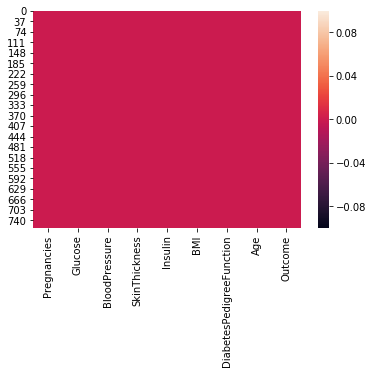

In [9]:
sns.heatmap(data.isnull())
#No missing data

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


What kind of values do the explanatory variables take?

In [20]:
data['Pregnancies'].unique()

array([ 6,  1,  8,  0,  5,  3, 10,  2,  4,  7,  9, 11, 13, 15, 17, 12, 14],
      dtype=int64)

(array([246., 178., 125.,  50.,  83.,  52.,  11.,  19.,   3.,   1.]),
 array([ 0. ,  1.7,  3.4,  5.1,  6.8,  8.5, 10.2, 11.9, 13.6, 15.3, 17. ]),
 <a list of 10 Patch objects>)

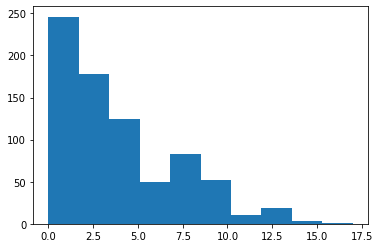

In [21]:
plt.hist(data['Pregnancies'])

Pregnancies can be numerical or categorical, I will assume it numerical.
Glucose, BloodPressure, SkinThickness, BMI, Insulin and PedigreeFunction and Age are numerical variables <br>

In [43]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


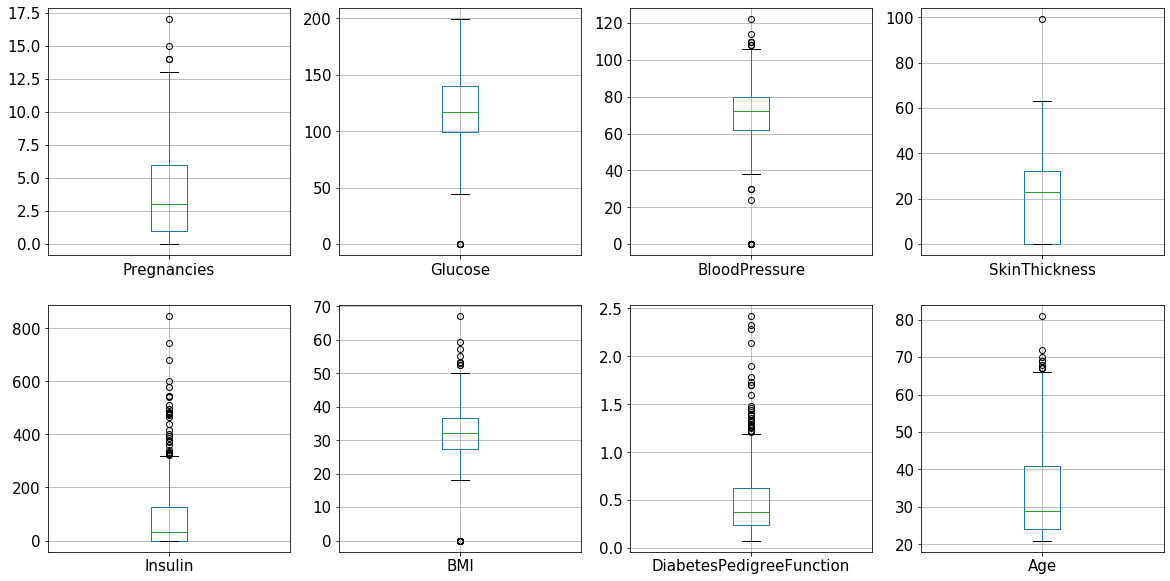

In [75]:
plt.figure(figsize=(20,10))
j=1
for i in data.columns:
    if i=='Outcome': pass
    else:
        plt.subplot(2,4,j)
        data.boxplot(column=i)
        j+=1

Many dsitributions are skewed usually in the same right direction. Insulin BMI and DiabetesPedigreeFunction have many outliers. <br>
Insulin has high variance.

# Group comparison

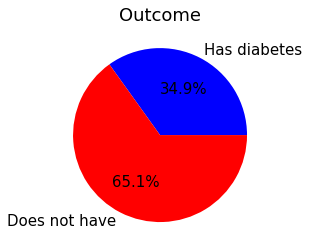

In [109]:
labels = 'Has diabetes', 'Does not have'
out=data['Outcome'].value_counts()
sizes = [out[1], out[0]]
colors = ['blue', 'red']
plt.rcParams['font.size'] = 15
plt.pie(sizes, labels=labels, colors=colors,autopct='%1.1f%%')
plt.title('Outcome')
plt.show()

In [93]:
grouped=data.groupby('Outcome').mean()
grouped=grouped.transpose()
grouped

Outcome,0,1
Pregnancies,3.298000,4.865672
Glucose,109.980000,141.257463
BloodPressure,68.184000,70.824627
SkinThickness,19.664000,22.164179
Insulin,68.792000,100.335821
BMI,30.304200,35.142537
DiabetesPedigreeFunction,0.429734,0.550500
Age,31.190000,37.067164


Text(0.5, 1.0, 'Mean comparison for both groups')

<Figure size 1440x1440 with 0 Axes>

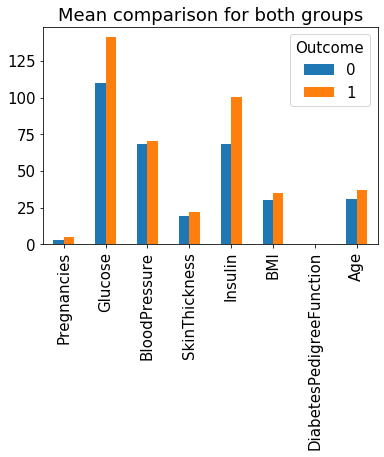

In [92]:
plt.figure(figsize=(20,20))
grouped.plot.bar()
plt.title('Mean comparison for both groups')

Each parameter has higher mean for the group with diabetes (Outcome=1).

In [104]:
#Creation of cross table, how many people have diabetes at each age, for example: when considering people of 21, 58 of them 
#don't have diabetes and 5 do
pd.crosstab(data['Age'],data.Outcome).head()

Outcome,0,1
Age,,
21,58,5
22,61,11
23,31,7
24,38,8
25,34,14


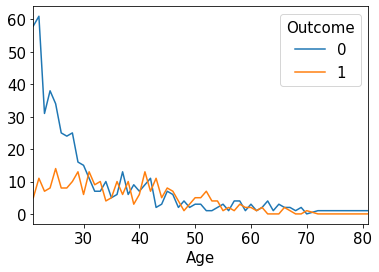

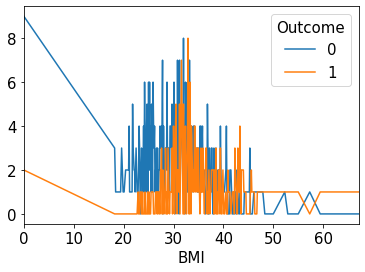

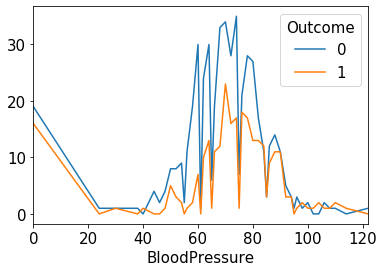

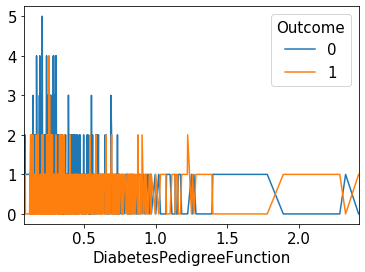

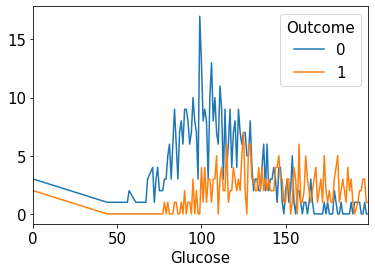

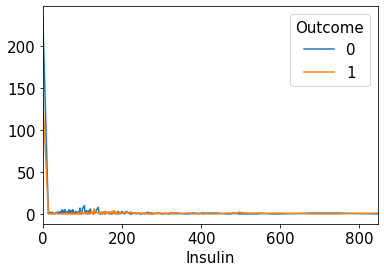

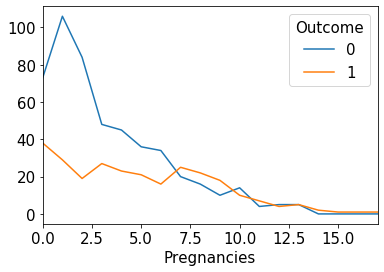

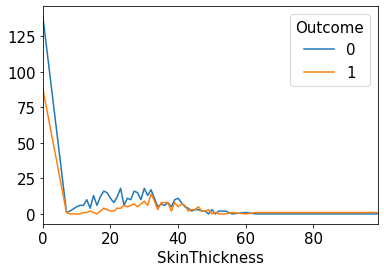

In [147]:
for i,j in zip(data.columns.difference(['Outcome']), range(1, len(data.columns.difference(['Outcome'])) +1) ):
    a=pd.crosstab(data[i],data['Outcome'])#.plot(kind='line')
    a.plot()

* Age - the majority of young people doesn't have diabetes, with age the proportion gets similar to 50%- 50%
* BMI - among people with low BMI, the majority doesn't have the disease, the higher it gets the more people have the disease
* Blood Pressure - it seems that the higher the blood pressure the more people have the diabetes
* DiabetesPedigreeFunction - hard to make any conclusion
* Glucose - people with low glucose tend to be healthy, people with high glucose tend to be sick
* Insulin - very similar curves
* Pregnancies - the majority of women with few pregnancies doesn't have the disease, the more pregnancies the propotion more similar to 50% - 50%
* SkinThickness - similar observation as before
It seems that all explanatory variables can have an impact on the response variable (some relation is lamost always observed).

In [11]:
corr_matrix=data.corr()
corr_matrix.style.background_gradient(cmap='coolwarm')

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1,0.129459,0.141282,-0.0816718,-0.0735346,0.0176831,-0.0335227,0.544341,0.221898
Glucose,0.129459,1,0.15259,0.0573279,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.15259,1,0.207371,0.0889334,0.281805,0.0412649,0.239528,0.0650684
SkinThickness,-0.0816718,0.0573279,0.207371,1,0.436783,0.392573,0.183928,-0.11397,0.0747522
Insulin,-0.0735346,0.331357,0.0889334,0.436783,1,0.197859,0.185071,-0.042163,0.130548
BMI,0.0176831,0.221071,0.281805,0.392573,0.197859,1,0.140647,0.0362419,0.292695
DiabetesPedigreeFunction,-0.0335227,0.137337,0.0412649,0.183928,0.185071,0.140647,1,0.0335613,0.173844
Age,0.544341,0.263514,0.239528,-0.11397,-0.042163,0.0362419,0.0335613,1,0.238356
Outcome,0.221898,0.466581,0.0650684,0.0747522,0.130548,0.292695,0.173844,0.238356,1


Rather no correlation problem, only age and preganacies are somehow connected (intuitive).

# Split of the data into training and set

In [18]:
len(data)

768

In [33]:
X = data[data.columns.difference(['Outcome'])]
Y = data['Outcome']
#Y = pd.get_dummies(data['Y'])
X_train,X_test,Y_train,Y_test = train_test_split(data.drop('Outcome',axis=1), data['Outcome'],test_size=0.2,random_state=0)

# Logistic Regression Model

In [51]:
model=LogisticRegression()
model.fit(X_train,Y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Analysis of the performance of the model for the training data

In [91]:
import matplotlib.pyplot as plt
predictions = model.predict(X_train)

In [61]:
#Predictions for X_train
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,accuracy_score
print(classification_report(Y_train, predictions))

              precision    recall  f1-score   support

           0       0.78      0.89      0.83       393
           1       0.73      0.55      0.63       221

    accuracy                           0.76       614
   macro avg       0.75      0.72      0.73       614
weighted avg       0.76      0.76      0.75       614



In [62]:
print('Accuracy score = correct predictions / total number of predictions:',accuracy_score(Y_train, predictions))

Accuracy score = correct predictions / total number of predictions: 0.7638436482084691


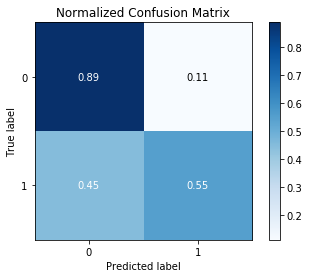

In [79]:
import scikitplot as skplt 
skplt.metrics.plot_confusion_matrix(Y_train, predictions, normalize=True)

The overall accuracy seems encouraging. However, the confusion matrix reveals that:
If there is no sicknes with propability 0.89 the model will give the true response (great!).
If there is sickness, then the decision is almost random. It can be happenning due to the fact that the size of the data about people without sickness is bigger than for those that have it. <br>
<b> Analysis of the performance for the test data <b>

In [95]:
predictions = model.predict(X_test)
print(classification_report(Y_test, predictions))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88       107
           1       0.76      0.60      0.67        47

    accuracy                           0.82       154
   macro avg       0.80      0.76      0.77       154
weighted avg       0.81      0.82      0.81       154



In [81]:
print('Accuracy score = correct predictions / total number of predictions:',accuracy_score(Y_test, predictions))

Accuracy score = correct predictions / total number of predictions: 0.8181818181818182


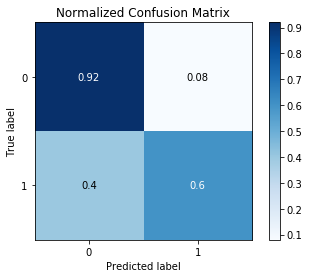

In [82]:
import scikitplot as skplt 
skplt.metrics.plot_confusion_matrix(Y_test, predictions, normalize=True)

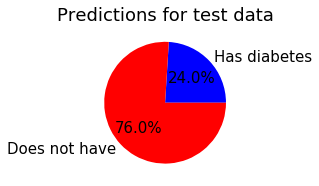

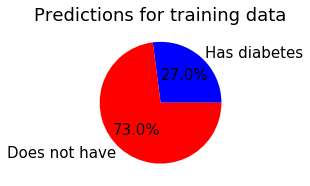

In [108]:
#predictions2 = model.predict(X_train)
predictions = model.predict(X_test)
pre={'pre':predictions}
pre=pd.DataFrame(pre)

plt.subplot(121)

labels = 'Has diabetes', 'Does not have'
out=pre['pre'].value_counts()
sizes = [out[1], out[0]]
colors = ['blue', 'red']
plt.rcParams['font.size'] = 15
plt.pie(sizes, labels=labels, colors=colors,autopct='%1.1f%%')
plt.title('Predictions for test data')
plt.show()

plt.subplot(122)

predictions = model.predict(X_train)
pre={'pre':predictions}
pre=pd.DataFrame(pre)

labels = 'Has diabetes', 'Does not have'
out=pre['pre'].value_counts()
sizes = [out[1], out[0]]
colors = ['blue', 'red']
plt.rcParams['font.size'] = 15
plt.pie(sizes, labels=labels, colors=colors,autopct='%1.1f%%')
plt.title('Predictions for training data')
plt.show()

## Conclusion about Logistic Regression
Model adjusts well to the reality when there is no disease. When it comes to detect the existing disease it performs slightly better than random.